# **Important Libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# **Loading & EDA**

In [2]:
df = pd.read_csv("/kaggle/input/rice-type-classification/riceClassification.csv",index_col=0)
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
id,,,,,,,,,,,
1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18185 entries, 1 to 18185
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             18185 non-null  int64  
 1   MajorAxisLength  18185 non-null  float64
 2   MinorAxisLength  18185 non-null  float64
 3   Eccentricity     18185 non-null  float64
 4   ConvexArea       18185 non-null  int64  
 5   EquivDiameter    18185 non-null  float64
 6   Extent           18185 non-null  float64
 7   Perimeter        18185 non-null  float64
 8   Roundness        18185 non-null  float64
 9   AspectRation     18185 non-null  float64
 10  Class            18185 non-null  int64  
dtypes: float64(8), int64(3)
memory usage: 1.7 MB


In [4]:
df.Class.value_counts(normalize=True)

Class
1    0.549079
0    0.450921
Name: proportion, dtype: float64

In [5]:
df.isna().sum()

Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Perimeter          0
Roundness          0
AspectRation       0
Class              0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df.describe()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
count,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000
mean,7036.492989,151.680754,59.807851,0.915406,7225.817872,94.132952,0.616653,351.606949,0.707998,2.599081,0.549079
std,1467.197150,12.376402,10.061653,0.030575,1502.006571,9.906250,0.104389,29.500620,0.067310,0.434836,0.497599
min,2522.000000,74.133114,34.409894,0.676647,2579.000000,56.666658,0.383239,197.015000,0.174590,1.358128,0.000000
25%,5962.000000,145.675910,51.393151,0.891617,6125.000000,87.126656,0.538530,333.990000,0.650962,2.208527,0.000000
50%,6660.000000,153.883750,55.724288,0.923259,6843.000000,92.085696,0.601194,353.088000,0.701941,2.602966,1.000000
75%,8423.000000,160.056214,70.156593,0.941372,8645.000000,103.559146,0.695664,373.003000,0.769280,2.964101,1.000000
max,10210.000000,183.211434,82.550762,0.966774,11008.000000,114.016559,0.886573,508.511000,0.904748,3.911845,1.000000


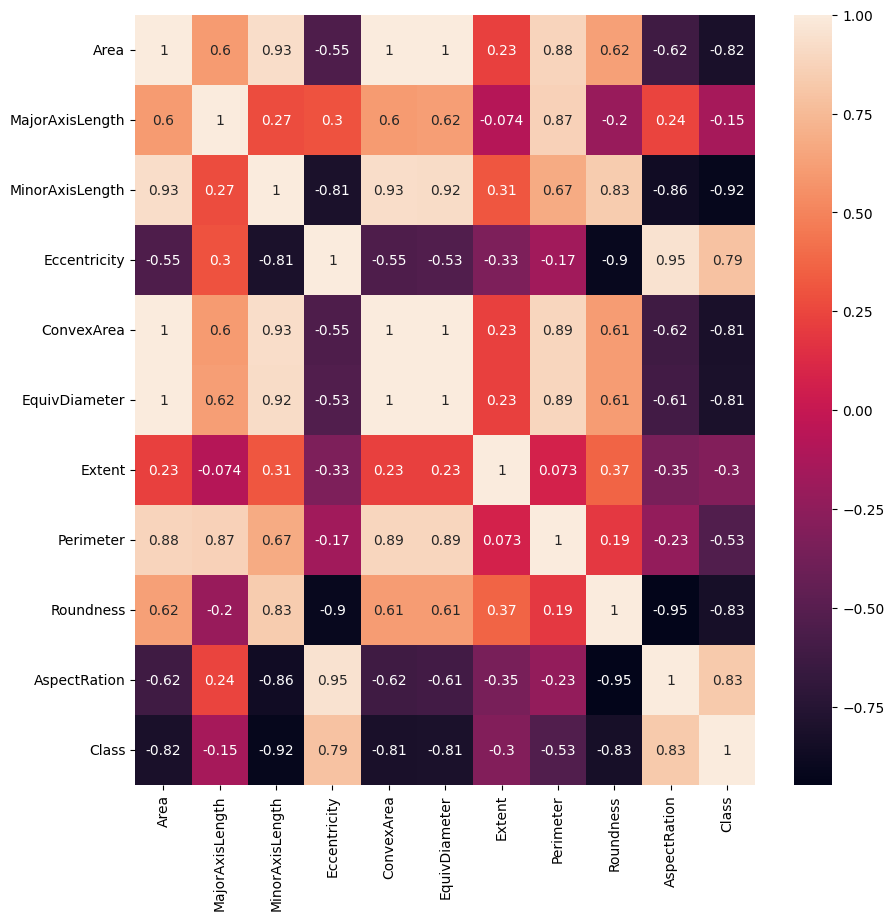

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True)
plt.show()

In [9]:
# Rescaling
for i in df.columns:
    df[i] = df[i] / df[i].abs().max()
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
id,,,,,,,,,,,
1,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
2,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
3,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
4,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
5,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


# **Data Spliting**

In [10]:
X = np.array(df.iloc[:,:-1])
y = np.array(df.iloc[:,-1])

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set is: ", X_train.shape[0], " rows which is ", round(X_train.shape[0]/df.shape[0],4)*100, "%") 
print("Validation set is: ",X_val.shape[0], " rows which is ", round(X_val.shape[0]/df.shape[0],4)*100, "%") 
print("Testing set is: ",X_test.shape[0], " rows which is ", round(X_test.shape[0]/df.shape[0],4)*100, "%")

Training set is:  12729  rows which is  70.0 %
Validation set is:  2728  rows which is  15.0 %
Testing set is:  2728  rows which is  15.0 %


In [12]:
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype = torch.float32).to(device)
        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

train_data = dataset(X_train, y_train)
val_data = dataset(X_val, y_val)
test_data = dataset(X_test, y_test)

In [13]:
# Hyper parameters
BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_NEURONS = 10
LR = 1e-3

In [15]:
train_loader = DataLoader(train_data,batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(val_data,batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(test_data,batch_size=BATCH_SIZE, shuffle=False)

# **Model**

In [16]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.input_layer = nn.Linear(X.shape[1],HIDDEN_NEURONS)
        self.linear = nn.Linear(HIDDEN_NEURONS,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [17]:
model = Model().to(device)
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [18]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr= LR)

In [22]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0
    ## Training and Validation
    for data in train_loader:

        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss = criterion(prediction, labels)

        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == labels).sum().item()

        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)

            batch_loss = criterion(prediction, labels)

            total_loss_val += batch_loss.item()

            acc = ((prediction).round() == labels).sum().item()

            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/(train_data.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(val_data.__len__())*100, 4))

    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(train_data.__len__())*100):.4f} Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(val_data.__len__())*100):.4f}''')
    print("="*50)

Epoch no. 1 Train Loss: 0.0384 Train Accuracy: 98.4052 Validation Loss: 0.0067 Validation Accuracy: 98.6437
Epoch no. 2 Train Loss: 0.0293 Train Accuracy: 98.4916 Validation Loss: 0.0055 Validation Accuracy: 98.6070
Epoch no. 3 Train Loss: 0.0247 Train Accuracy: 98.4838 Validation Loss: 0.0048 Validation Accuracy: 98.6070
Epoch no. 4 Train Loss: 0.0221 Train Accuracy: 98.6016 Validation Loss: 0.0045 Validation Accuracy: 98.5337
Epoch no. 5 Train Loss: 0.0204 Train Accuracy: 98.5702 Validation Loss: 0.0042 Validation Accuracy: 98.5704
Epoch no. 6 Train Loss: 0.0194 Train Accuracy: 98.6330 Validation Loss: 0.0041 Validation Accuracy: 98.6070
Epoch no. 7 Train Loss: 0.0186 Train Accuracy: 98.5545 Validation Loss: 0.0039 Validation Accuracy: 98.6070
Epoch no. 8 Train Loss: 0.0184 Train Accuracy: 98.4995 Validation Loss: 0.0039 Validation Accuracy: 98.5337
Epoch no. 9 Train Loss: 0.0177 Train Accuracy: 98.5623 Validation Loss: 0.0039 Validation Accuracy: 98.5704
Epoch no. 10 Train Loss: 0.0

# **Evaluation**

In [25]:
with torch.no_grad():
    total_loss = 0
    total_acc = 0
    for data in test_loader:
        inputs, label = data
        prediction = model(inputs).squeeze(1)
        loss = criterion(prediction, label)
        total_loss += loss.item()
        acc = ((prediction).round() == label).sum().item()
        total_acc += acc
print(f"Accuracy Score is: {round((total_acc/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 99.05%


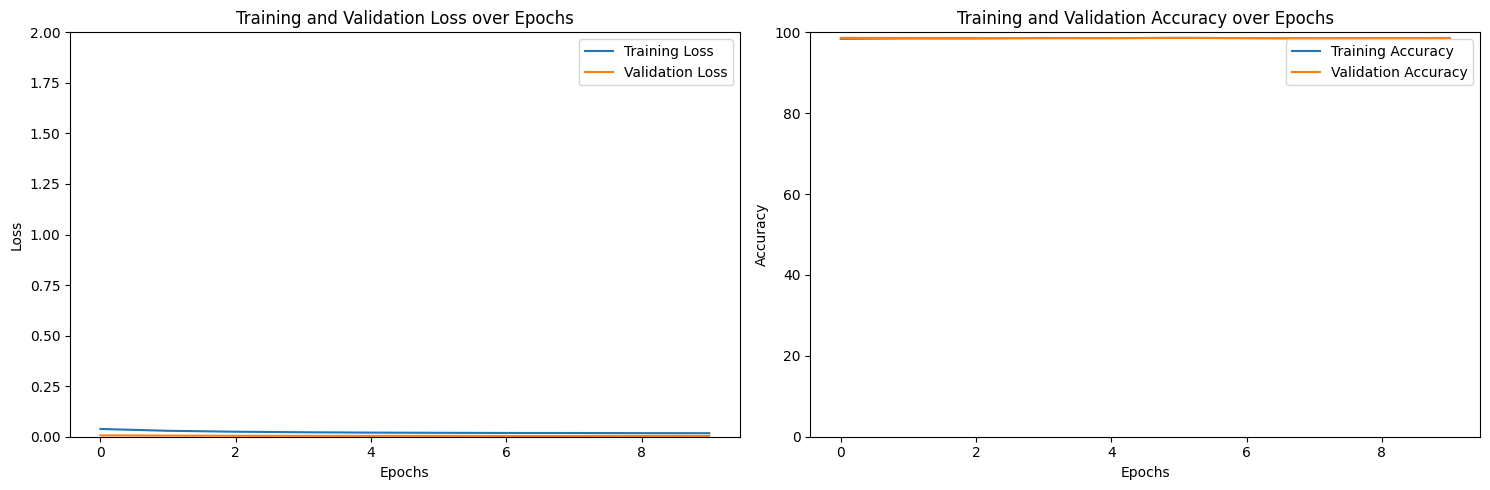

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()